**Project Repository:** https://github.com/GokulKarthik/deep-learning-projects-pytorch

In [1]:
import os
import time
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

import string
from collections import Counter

In [2]:
writer = SummaryWriter(os.path.join("runs", "baby-names"))

## 1. Load data

[This Kaggle dataset](https://www.kaggle.com/kaggle/us-baby-names#NationalNames.csv) has names of the child born from 1880 to 2014 along with other features such as Gender and Count. I am going to use this to build a name generator model using sampling of the trained character level LSTM network

In [3]:
data_path = os.path.join("data", "baby-names", "NationalNames.csv")
data = pd.read_csv(data_path)
print(data.shape)
data.head()

(1825433, 5)


,Id,Name,Year,Gender,Count
0,1,Mary,1880,F,7065
1,2,Anna,1880,F,2604
2,3,Emma,1880,F,2003
3,4,Elizabeth,1880,F,1939
4,5,Minnie,1880,F,1746


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825433 entries, 0 to 1825432
Data columns (total 5 columns):
Id        int64
Name      object
Year      int64
Gender    object
Count     int64
dtypes: int64(3), object(2)
memory usage: 69.6+ MB


## 2. Clean data

In [5]:
def clean(name):
    
    name = name.lower().strip()
    name = "".join([c for c in name if c in string.ascii_lowercase])
    name += "."
    return name

In [6]:
data['Name'] = data['Name'].apply(clean)
data.head()

,Id,Name,Year,Gender,Count
0,1,mary.,1880,F,7065
1,2,anna.,1880,F,2604
2,3,emma.,1880,F,2003
3,4,elizabeth.,1880,F,1939
4,5,minnie.,1880,F,1746


In [7]:
names = data[['Name', 'Count']].groupby('Name').sum()
del names.index.name
print(len(names))
names.head()

93889


,Count
aaban.,72
aabha.,21
aabid.,5
aabriella.,10
aadam.,196


In [8]:
pd.Series(names.index).apply(len).max()

16

In [9]:
max_length = 11
len_filter = pd.Series(names.index).apply(lambda x: len(x)<=max_length).tolist() # max length of 10 excluding '.'
print(len_filter[:10])
print(names.shape)
names = names[len_filter]
print(names.shape)

[True, True, True, True, True, True, True, True, True, True]
(93889, 1)
(92889, 1)


In [10]:
pd.Series(names.index).apply(len).max()

11

In [11]:
names = names.sort_values(by=['Count'], ascending=False)
names.head()

,Count
james.,5129096
john.,5106590
robert.,4816785
michael.,4330805
mary.,4130441


## 3. Set training data

We need a list of names to start building the name generator model. One naive approach for this dataset could be to just take list of unique names. The number of uniques names is 93889, which is large. So, if we sample uniformly from the unique names, the model may learn to generate uncommon and less interesting names. Also if we use the exact counts the model will generate more common names. So we have to sample in between these two. Normalized counts can be used to sample for training.

In [12]:
names['Count'].describe()

count    9.288900e+04
mean     3.606536e+03
std      5.557699e+04
min      5.000000e+00
25%      1.100000e+01
50%      4.500000e+01
75%      2.400000e+02
max      5.129096e+06
Name: Count, dtype: float64

In [13]:
alpha = 0.8
names['Count'].apply(lambda x: np.power(x, alpha)).apply(np.int).describe()

count     92889.000000
mean        342.499295
std        3211.942902
min           3.000000
25%           6.000000
50%          21.000000
75%          80.000000
max      233363.000000
Name: Count, dtype: float64

In [14]:
names['count_normalized'] = names['Count'].apply(lambda x: np.power(x, alpha)).apply(np.int)
names.head()

,Count,count_normalized
james.,5129096,233363
john.,5106590,232543
robert.,4816785,221924
michael.,4330805,203823
mary.,4130441,196244


In [15]:
count_normalized_sum = names['count_normalized'].sum()
print(count_normalized_sum)

31814417


In [16]:
names['p'] = names['count_normalized'] / count_normalized_sum
names.head()

,Count,count_normalized,p
james.,5129096,233363,0.007335
john.,5106590,232543,0.007309
robert.,4816785,221924,0.006976
michael.,4330805,203823,0.006407
mary.,4130441,196244,0.006168


In [17]:
np.random.seed(0)
names_list = np.random.choice(names.index, size=10**5, p=names['p'], replace=True)
print(len(names_list))
print(names_list[:50])

100000
['joanna.' 'pearlie.' 'harrison.' 'kay.' 'kim.' 'braden.' 'bernard.'
 'eugena.' 'essynce.' 'audrey.' 'sharla.' 'oliver.' 'susie.' 'meka.'
 'patricia.' 'donald.' 'robert.' 'sheyla.' 'lizeth.' 'tayden.' 'casmira.'
 'karmen.' 'dean.' 'danita.' 'ronald.' 'mona.' 'frank.' 'kareemah.'
 'mackenzie.' 'thelma.' 'grace.' 'kami.' 'gertrude.' 'misty.' 'robert.'
 'horace.' 'gerard.' 'salvatore.' 'iyannah.' 'hillary.' 'edna.' 'holly.'
 'simone.' 'thomas.' 'ronda.' 'helena.' 'katherine.' 'helen.' 'madison.'
 'dawn.']


In [18]:
pd.Series(names_list).value_counts()

james.       733
john.        724
robert.      677
michael.     649
william.     605
            ... 
laveta.        1
nakeysha.      1
ramin.         1
vega.          1
soliyana.      1
Length: 16785, dtype: int64

In [19]:
del data, names

## 3. Define utilities

In [20]:
chars = "." + string.ascii_lowercase
num_chars = len(chars)
print(chars)
print(num_chars)

.abcdefghijklmnopqrstuvwxyz
27


In [21]:
char_to_id = {c:i for i, c in enumerate(chars)}
id_to_char = {v:k for k, v in char_to_id.items()}
print(char_to_id)
print(id_to_char)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [22]:
print(max_length)

11


## 4. Define dataset

In [23]:
class NamesDataset(Dataset):
    
    def __init__(self, names_list):
        self.names_list = names_list
        
    def __len__(self):
        return len(self.names_list)
    
    def __getitem__(self, idx):
        x_str = self.names_list[idx].ljust(max_length, ".")[:max_length]
        y_str = x_str[1:] + "."
        
        x = torch.zeros((max_length, num_chars))
        y = torch.zeros(max_length)
        for i, c in enumerate(x_str):
            x[i, char_to_id[c]] = 1
        for i, c in enumerate(y_str):
            y[i] = char_to_id[c]
            
        return x, y

In [24]:
trainset = NamesDataset(names_list)

## 5. Define dataloader

In [25]:
train_batch_size = 256

In [26]:
cpu_count = os.cpu_count()
print(cpu_count)

8


In [27]:
train_loader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=cpu_count)
print(len(train_loader))

391


In [28]:
train_iter = iter(train_loader)
X, Y = train_iter.next()
print(X.size(), Y.size())

torch.Size([256, 11, 27]) torch.Size([256, 11])


## 6. Define model

In [29]:
input_size = num_chars
hidden_size = 54
output_size = num_chars
num_layers = 1

In [30]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [31]:
class Model(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(output_size, output_size)
        
    def forward(self, X, states):
        ht, ct = states
        batch_size = X.size(0)
        out, (ht, ct) = self.lstm1(X, (ht, ct))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out, (ht, ct) # out: Size([batch_size, max_length, num_chars])

In [32]:
model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
model = nn.DataParallel(model)
model = model.to(device)

In [33]:
#list(model.parameters())

In [34]:
ht = torch.zeros((num_layers, train_batch_size, hidden_size)).to(device)
ct = torch.zeros((num_layers, train_batch_size, hidden_size)).to(device)
writer.add_graph(model, (X, (ht, ct)))
writer.close()

In [35]:
#summary(model, input_size=(max_length, num_chars))

## 7. Set optimizer

In [36]:
lr = 0.005
step_size = len(train_loader) * 1
gamma = 0.95
print(step_size)

391


In [37]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

## 8. Define sampler

In [38]:
def generate_name(model, start='a', k=5):
    
    if len(start) >= max_length:
        return name
    
    with torch.no_grad():
        
        ht = torch.zeros((num_layers, 1, hidden_size)).to(device)
        ct = torch.zeros((num_layers, 1, hidden_size)).to(device)
        length = 0
        name = start
        
        for char in start:
            X = torch.zeros((1, 1, num_chars)) # [batch_size, timestep, num_chars]
            X[0, 0, char_to_id[char]] = 1
            out, (ht, ct) = model(X, (ht, ct))
            length += 1
        vals, idxs = torch.topk(out[0], k) # 0 -> first eg in a batch
        idx = np.random.choice(idxs.cpu().numpy()[0]) # 0 -> first...
        char = id_to_char[idx]
        vals, idxs = torch.topk(out[0], k) # 0 -> first eg in a batch
        idx = np.random.choice(idxs.cpu().numpy()[0]) # 0 -> first...
        char = id_to_char[idx]
        
        while char != "." and length <= max_length-1:
            X = torch.zeros((1, 1, num_chars)) # [batch_size, timestep, num_chars]
            X[0, 0, char_to_id[char]] = 1
            out, (ht, ct) = model(X, (ht, ct))
            vals, idxs = torch.topk(out[0], k) # 0 -> first eg in a batch
            idx = np.random.choice(idxs.cpu().numpy()[0]) # 0 -> first...
            char = id_to_char[idx]
            length += 1
            name += char
    
        if name[-1] != ".":
            name += "."
    
    return name

In [39]:
def sampler(model, start='a', n=10, k=5, only_new=False):
    
    names = []
    cnt = 0
    while cnt <= n:
        name = generate_name(model=model, start=start, k=k)
        if only_new: 
            if name not in names_list and name not in names:
                names.append(name)
                cnt += 1
        else:
            if name not in names:
                names.append(name)
                cnt += 1
    names = [name[:-1].title() for name in names]
    
    return names

## 9. Train model

In [40]:
epochs = 50
print_every_n_epochs = epochs // 10

In [41]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs+1), desc="Epochs"):
    epoch_loss = 0
    epoch_lr = 0
    
    for i, (X, Y) in tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="Epoch-{}".format(epoch)):
    #for i, (X, Y) in enumerate(train_loader, 1):
        X, Y = X.to(device), Y.to(device)
        
        ht = torch.zeros((num_layers, X.size(0), hidden_size)).to(device)
        ct = torch.zeros((num_layers, X.size(0), hidden_size)).to(device)

        optimizer.zero_grad()
        Y_pred_logits, (ht, ct) = model(X, (ht, ct))
        Y_pred_logits = Y_pred_logits.transpose(1, 2) # Check Loss Doc: [N, d1, C] -> [N, C, d1]
        loss = criterion(Y_pred_logits, Y.long())
        loss.backward(retain_graph=True)
        optimizer.step()
        lr_scheduler.step()
        
        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_lr()[0]
        
    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)
    
    if epoch % print_every_n_epochs == 0:    
        message = "Epoch:{}    Loss:{}    LR:{}".format(epoch, epoch_loss, epoch_lr)
        print(message)
        names = sampler(model, start='jo', n=10, k=10, only_new=False)
        print(names)


Epoch:5    Loss:0.7167906203233373    LR:0.004072010465952698
['Jo', 'Jockahanthu', 'Jockrueunou', 'Joiskaish', 'Joalspierro', 'Jodudenoaev', 'Jofryatiuss', 'Joasuckatuu', 'Jofr', 'Joedepn', 'Joalknrif']



Epoch:10    Loss:0.6500418820344579    LR:0.003150844075854658
['Jo', 'Joccuhnonfu', 'Joeffban', 'Jotuur', 'Joikan', 'Jofhelaosre', 'Joomndyalat', 'Josteyeoaur', 'Joahkuyso', 'Johos', 'Johuamnoaet']



Epoch:15    Loss:0.628477140003458    LR:0.0024380630829311453
['Jondwoods', 'Joyaa', 'Joatna', 'Jodurahzd', 'Jo', 'Johyscallay', 'Jorevciaa', 'Joc', 'Joodheutd', 'Joeciu', 'Joiataa']



Epoch:20    Loss:0.6171540706358907    LR:0.0018865267379945911
['Joey', 'Johutijutst', 'Jostndsousc', 'Jommoraen', 'Jo', 'Jolinya', 'Joecoma', 'Jomiahu', 'Joo', 'Joittos', 'Jodw']



Epoch:25    Loss:0.6102617177207147    LR:0.001459758427944281
['Joc', 'Joeniyuarai', 'Jokaseep', 'Joaichkud', 'Joy', 'Jocuesnahtu', 'Joclycobyhu', 'Jo', 'Jomiuazhahh', 'Jopof', 'Jomysoasope']



Epoch:30    Loss:0.6054451810124585    LR:0.0011295332448982476
['Jonklsyn', 'Jod', 'Jouier', 'Joy', 'Jodrihia', 'Joe', 'Jo', 'Josisolsoux', 'Joastue', 'Jopath', 'Jochos']



Epoch:35    Loss:0.6017337508518678    LR:0.0008740112931747908
['Jorbida', 'Joo', 'Jobrehk', 'Jostnayeeru', 'Jondicuzy', 'Jocqquatey', 'Jodalaeyato', 'Joazauescii', 'Joec', 'Joduothirlu', 'Jopk']



Epoch:40    Loss:0.5992579830577002    LR:0.0006762932778183793
['Jo', 'Jopkstosnie', 'Joi', 'Joeetn', 'Jociuonawoa', 'Joy', 'Jopeettiahl', 'Joannetswuy', 'Johchysqw', 'Jono', 'Joairby']



Epoch:45    Loss:0.5973198051037996    LR:0.0005233028465352523
['Johyontharw', 'Joacey', 'Josouahhosu', 'Jonnaodenga', 'Jophetosuno', 'Joolad', 'Joaient', 'Jo', 'Jobahahu', 'Joordhyhido', 'Joicett']



Epoch:50    Loss:0.595893286835507    LR:0.0004049217671884643
['Joisepaauih', 'Jospyfaiory', 'Joem', 'Jodseetalmr', 'Jondigtnunl', 'Joemosnwnyn', 'Jopcr', 'Jobaet', 'Jop', 'Josceiobyss', 'Jo']



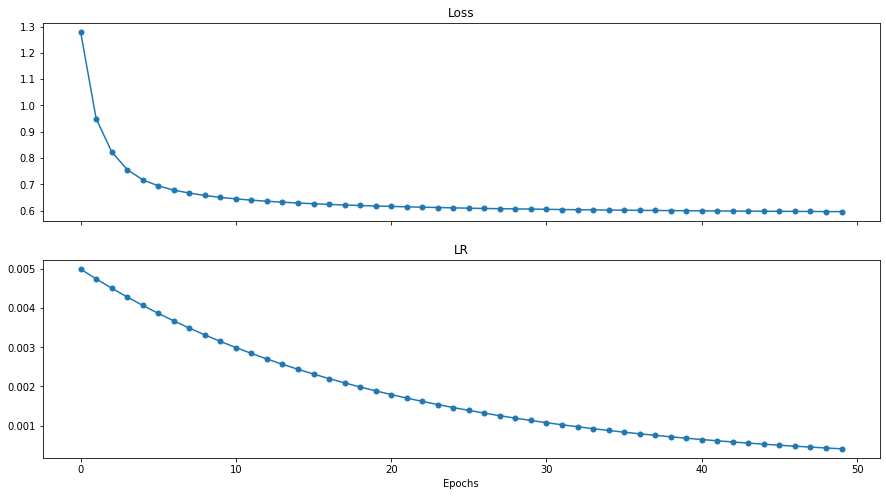

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(epoch_losses, marker="o", markersize=5)
ax1.set_title("Loss")
ax2.plot(epoch_lrs, marker="o", markersize=5)
ax2.set_title("LR")
plt.xlabel("Epochs")
plt.show()

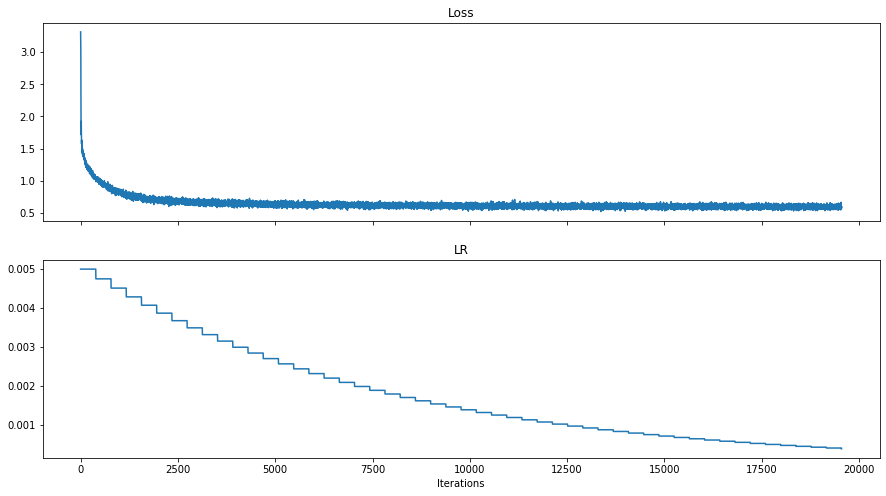

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(iteration_losses[::])
ax1.set_title("Loss")
ax2.plot(iteration_lrs[::])
ax2.set_title("LR")
plt.xlabel("Iterations")
plt.show()

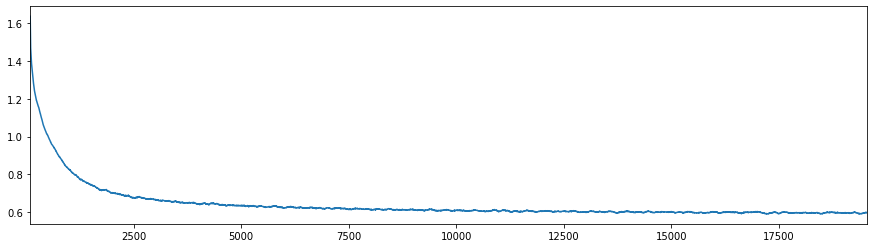

In [44]:
window = 100
plt.figure(figsize=(15, 4))
pd.Series(iteration_losses).rolling(window=window).mean().iloc[window-1:].plot()
plt.show()

In [45]:
path = os.path.join("models", "language-words", "classifier.pth")
torch.save(model.state_dict(), path)

## 10. Generate new baby names

In [47]:
path = os.path.join("models", "language-words", "classifier.pth")
model = Model(input_size=num_chars, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [48]:
names = sampler(model, start='indi', n=10, k=5, only_new=True)
print(names)

['Indi', 'Indiahwste', 'Indill', 'Indiaahiter', 'Indikol', 'Indina', 'Indiwa', 'Inditaneahn', 'Indinnaisha', 'Indilytofer', 'Indinta']


In [49]:
names = sampler(model, start='herb', n=10, k=5, only_new=False)
print(names)

['Herbshw', 'Herbahwno', 'Herbet', 'Herbnollo', 'Herbahahaos', 'Herbhnahia', 'Herbhmopee', 'Herb', 'Herbney', 'Herbrinerah', 'Herbsty']


In [50]:
names = sampler(model, start='su', n=10, k=5, only_new=True)
print(names)

['Sul', 'Sumurio', 'Suianohonor', 'Suunn', 'Sumosgi', 'Su', 'Suphuroncio', 'Suieua', 'Sumoriusumi', 'Supyruco', 'Suresse']


In [51]:
names = sampler(model, start='vis', n=10, k=5, only_new=True)
print(names)

['Vistoapar', 'Visceranosg', 'Visni', 'Visti', 'Visan', 'Vissno', 'Vissia', 'Visshiashot', 'Visora', 'Visanell', 'Vistoo']


In [52]:
names = sampler(model, start='a', n=10, k=3, only_new=True)
print(names)

['Aleyanarano', 'Aishi', 'Aissond', 'Aexine', 'Atura', 'Alas', 'Athenele', 'Aicely', 'Athel', 'Aejuan', 'Adya']


In [53]:
names = sampler(model, start='a', n=10, k=8, only_new=True)
print(names)

['Aaulosnikem', 'Aye', 'Ahaynzas', 'Adidr', 'Ane', 'Ahennofeeon', 'As', 'Aich', 'Asroctonait', 'Aaynemaednu', 'Afobiamairi']


In [54]:
names = sampler(model, start='a', n=10, k=15, only_new=True)
print(names)

['Abckyeua', 'Amiyazcioto', 'Adwoykhurk', 'Ass', 'Anisklwuto', 'Aunnt', 'Ay', 'Atimliitefy', 'A', 'Achzesqahsp', 'Aopldookksy']


In [55]:
names = sampler(model, start='jam', n=10, k=2, only_new=False)
print(names)

['James', 'Jamel', 'Jame', 'Jamso', 'Jamshah', 'Jams', 'Jamela', 'Jamelahana', 'Jamsha', 'Jamesh', 'Jamson']
